# Microbial Fuel Cells

Microbial fuel cells (MFC) are bio-electrochemical systems mainly used to generate energy
from living electroactive bacteria or fungi due to their metabolic processes. It can also be
utilised to produce a certain product or for specific environmental advantages, such as
wastewater treatment. One of the ways to curb climate change is to employ renewable bioenergy from wastes, resulting in a neutral or even negative carbon footprint. 

## How do MFC work?

Now that you are familiar with the reduction reaction of $NAD^{+}$ to NADH, we can now include it in our MFC discussion, [recap on NADH](https://www.youtube.com/watch?v=Kb-4uuCYLvE).
As we know by now mitochondria are the energy powerhouses of the cell by accumulating or releasing chemical energy in the form of substrates like NADH or NADPH. These substrates transfer electrons to the metabolites and when the process is carried out in anaerobic conditions, NADH and NADPH become electroactive. 

In [1]:
#<img src ="Mito.jpg" style=width:357px;height:328px/>

![](Mito.jpg)

The operating principle comprises of the division of the half reactions of oxidation and reduction in two seperate compartments. In the anodic compartment, electroactive bacteria catalyse substrate by oxidation in anaerobic conditions and transfer the electrons to the electrode. These electrons then flow through an external electrical circuit to the cathodic compartment where oxygen is the electron acceptor and reduced in aerobic conditions. To ensure neutrality, the $H^{+}$ flows through a cation permeable membrane to the cathodic compartment.  

![Figure 1: MFC diagram](MFCdiagram.png)

Let's have a look at the following equation in cmol balance form:

$$ C H_{2} O + NH_{3} \to C H_{1.8} O_{0.5} N_{0.2} + CO_{2} + H^{+} + e^{-} $$

#### This equation looks very familiar!

In the equation above glucose is the substrate used and ammonia is used as a nitrogen source for the bacteria. Although every bacteria has their very own chemical formula, we will be using that of the familiar biomass estimation, X. The only addition from previous work, is the hydrogen atom, represented as an electron and proton. Balancing this equation is done as in previous chapters. Let's try and balance the above equation.

$$(-r_S)\ CH_2 O+(-r_A)\ NH_3 \to (r_{X})\ CH_{1.8} O_{0.5} N_{0.2} +(r_C)\ CO_2 + (r_H)\ H $$

As said earlier the proton and electron can be seen as a hydrogen atom for simplicity of the balance. The proton and electron will then have the same stoichiometric coefficient as hydrogen, as can be seen below,

$$ YH \to YH^{+} + Ye^{-} $$

The matrix will look at follows, 

$$\begin{bmatrix}-1&0&1&1&0\\-2&-3&1.8&0&1\\-1&0&0.5&2&0\\0&1&0.2&0&0\\1&0&0&0&0\end{bmatrix}\times\begin{bmatrix}-r_S\\-r_A\\r_{X}\\r_C\\r_H\end{bmatrix}=\begin{bmatrix}0\\0\\0\\0\\1\end{bmatrix}$$


And solving in python:

In [2]:
import numpy
S = numpy.matrix([[-1, 0, 1, 1, 0],  
                  [-2, -3, 1.8, 0,1], 
                  [-1, 0, 0.5, 2, 0],
                  [0, -1, 0.2, 0, 0],
                  [1, 0, 0, 0, 0]])

C = numpy.matrix([[0,0,0,0,1]]).T
Y = numpy.linalg.solve(S,C)
print(Y)
print(Y[0,0])
print (Y[1,0])

[[1.        ]
 [0.13333333]
 [0.66666667]
 [0.33333333]
 [1.2       ]]
1.0
0.13333333333333333


Thus the balanced equation will have the following form,

$$ CH_2 O+ \frac{2}{15} NH_3 \to  \frac{2}{3} CH_{1.8} O_{0.5} N_{0.2} + \frac{1}{3}CO_2 + 1.2H^+ +1.2e^- $$


As can be seen by the equation above, for every cmol of glucose, 1.2 mol electrons are formed that will flow through the external electrical circuit. We will now model the equation in a batch reactor using a similiar method to that what was used to model bacth fermentation. As the volume in a bacth reactor doesn't change, it creates very simple differential equations. 

\begin{align*}
\text{Biomass: }&\frac{dC_X}{dt}=r_X C_X -K_dC_X\\
\text{Substrate: }&\frac{dC_S}{dt}=-r_S C_X \\
\text{Hydrogen: }&\frac{dC_H}{dt}=r_H C_X \\
\end{align*}

Where, S, is the substrate (glucose in this case) and X, is the biomass. $K_{d}$ is known as the bacterial endogenous decay coefficient and can be assumed to be 0.02 $\mu_{max}$. This will be considered later and for now it is assumed the bacteria doesn't decay. Monod kinetics are assumed for the growth of the bacteria using the following equation:

$$ \mu = \mu_{max} \frac{C_S}{K_M + C_S} $$

Let's try solving the differential equations. First we will define the required parameters:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.12
K_M = 0.0004

c_S_0 = 5/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

As can be observed by the cell above, the molar mass of the biomass is calculated. There are parameters given for $\mu_{max}$ and $K_{m}$, respectively. The initial values of the substrate, $C_{S}$ and biomass, $C_{X}$, is given in units of grams and then converted to cmols. As for the volume, it will stay unchanged at 1 L, as it is a batch reactor, but might change later when we consider CSTR's.

In [4]:
def rates(var):
    c_S, c_X, c_H, c_C, V = var
    
    mu = mu_max*c_S/(K_M + c_S)
    
    S_base = np.matrix([[1,    0,    1,     1,    0,  ],
                        [2,    3,    1.8,   0,    1,  ],
                        [1,    0,    0.5,   2,    0,  ],
                        [0,    1,    0.2,   0,    0   ]])
#                       rS,   rA,   rX,    rC,   rH  
#                       r[0], r[1], r[2],  r[3], r[4] 

    S_spec = [1, 0, 0, 0, 0] # S0
    A_spec = [0, 1, 0, 0, 0] # S1
    X_spec = [0, 0, 1, 0, 0] # S2
    C_spec = [0, 0, 0, 1, 0] # S3
    H_spec = [0, 0, 0, 0, 1] # S4
    
    S = np.vstack([S_base, X_spec])
    C = np.array([0, 0, 0, 0, mu])
    r = np.linalg.solve(S, C)
    return r

Here, the same first 4 rows of the matrix used above, is implemented. Anyone of the 5 specifications can be used. The specification of the biomass was implemented here, thus making the biomass our basis. Numpy.vstack allows you to add another row into an existing matrix. It is then solved as usual.

In [5]:
def ferm(var, t):
    c_S, c_X, c_H, c_C, V = var
    
    r_S, r_A, r_X, r_C, r_H = rates(var)

    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Hdt = r_H*c_X
    dc_Cdt = r_C*c_X
    dVdt = 0
    return dc_Sdt, dc_Xdt, dc_Hdt, dc_Cdt, dVdt

The three differential equations are now included in the 'ferm' function and ready to be integrated! Note, as stated earlier, the decay coefficient, $K_{d}$ will not be considered now.
As it is a batch reactor, the change in volume is zero. 

In [6]:
c_i_0 = [c_S_0, c_X_0, c_H_0, 0, V_0]
tspan = np.linspace(0.000001, 80, 101)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_H, c_C, V = c_i.T

The differential equation are solved using odeint from the scipy.integrate module.

Although the concentration of all the considered species, $C_{S}$, $C_{X}$ and $C_{H}$ have been calculted, we are interested in the rates of how the increase/decrease. We simply make lists and append the corresponding rate value to the list. Why we do this become apperent later...

In [7]:
list_cS = []
list_cX = []
list_cH = []

for i in range(0, len(c_S)):
    r_S, r_A, r_X, r_C, r_H = rates([c_S[i], c_X[i], c_H[i], c_C[i], V[i]])
    list_cS.append(r_S)
    list_cX.append(r_X)
    list_cH.append(r_H)
    
r_S = np.array(list_cS)
r_H = np.array(list_cH)

Finally, we plot our results.

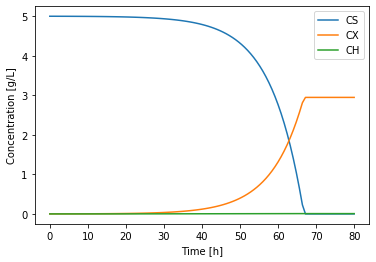

In [37]:
plt.plot(tspan, c_S*30, label = 'CS')
plt.plot(tspan, c_X*MMX, label = 'CX')
plt.plot(tspan, c_H*1, label = 'CH')
plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

Let's have a look at the following plot.

Text(0.5, 0, 'Time [h]')

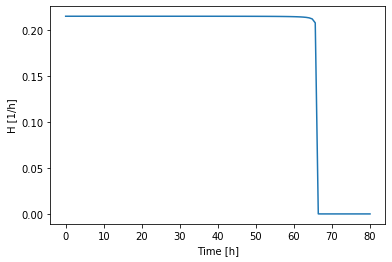

In [9]:
plt.plot(tspan, r_H)
plt.ylabel('H [1/h]')
plt.xlabel('Time [h]')

What do you see?


As we mentioned earlier, hydrogen consists of a proton and electron. The rate of hydrogen production stays constant at 0.216 $\frac{mol \ H}{cmol \ X \cdot h}$, but at t = 67 h, drops to zero, due to glucose being depleted. To get a better look at the production of hydrogen we will plot $C_{H}$ vs time on its own axis.

Text(0.5, 0, 'Time [h]')

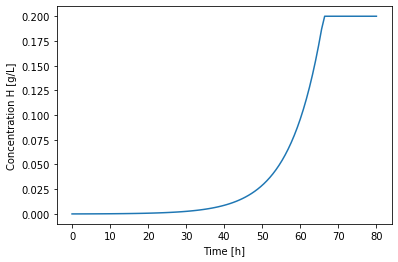

In [10]:
plt.plot(tspan, c_H*1, label = 'CH')
plt.ylabel('Concentration H [g/L]')
plt.xlabel('Time [h]')

How do you calculate current from here? Well, current has units of ampere, which is coulumb per second. If we dig deep enough into high school chemistry, there exists a relationship between moles and coulomb...


But don't make the mistale of using the molar or mass concentration to calculate the amperes, as dividing the concentration by time will give u a differential over the whole time span, rather than at every required time point in the list. Thus we will convert the biomass based rate of hydrogen production to an absolute hydrogen production rate value. We can do this by multiplying by the concentration of biomass and the volume. It will be easier to explain how the units check out visually.

$$ r_H [\frac{mol \ H}{cmol \ X \cdot h}] \times c_X [\frac{cmol \ X}{L}] \times V [L] \times \frac{h}{60 \ minutes}\times \frac{minutes}{60 \ seconds} = F_H [\frac{mol \ H}{s}]$$

Text(0.5, 0, 'Time [h]')

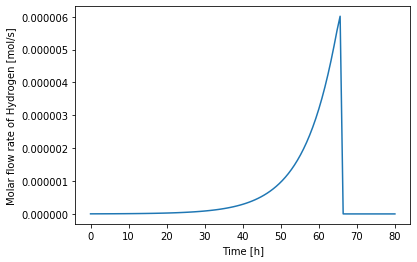

In [11]:
F_H = r_H*c_X*V*(1/60)*(1/60)

plt.plot(tspan, F_H)
plt.ylabel('Molar flow rate of Hydrogen [mol/s]')
plt.xlabel('Time [h]')

*If we now take this from a mass concentration to a molar concentration (it will effectively stay unchanged as the molar mass of hydrogen is 1).* Now that we have molar flow rate, $F_{H}$, we can go to the next step. Remember something called Avogadro's number? It can convert moles to atoms by multiplying by 6.022 $\times$ $10^{23}$. Let's calculate how many hydrogen atoms are present in the reactor at a specific time,

Text(0.5, 0, 'Time [h]')

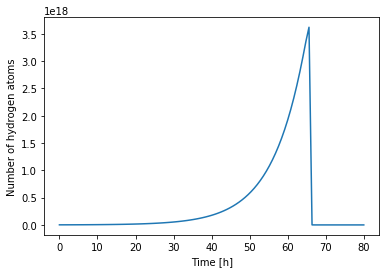

In [12]:
H_atoms = F_H*6.022e23
plt.plot(tspan, H_atoms)
plt.ylabel('Number of hydrogen atoms')
plt.xlabel('Time [h]')

Now comes the part that has been repeated numerous times. A hydrogen consists of a proton and a electron, this means the amount of hydrogen atoms equals the amount of electrons and the charge of one electron is equal to 1.60217646 $\times$ $10^{-19}$ coulomb and as stated earlier coulomb per second is ampere! And as we already have the number of hydrogen atoms and electrons in a per second basis, multiply by the charge of an electron will automatically give coulomb per second, which equates to amperes.

Text(0.5, 0, 'Time [h]')

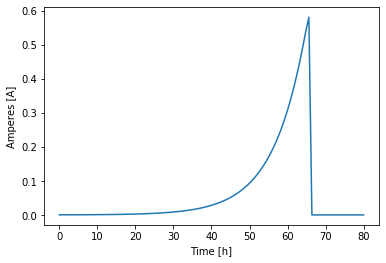

In [13]:
N_electrons = H_atoms
Coulomb_per_second = N_electrons*1.60217646e-19

Ampere = Coulomb_per_second

plt.plot(tspan, Ampere)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

And there it is the current produced over time from our biomass using glucose. Some interesting observations can be made. 

The amount of amperes produced, increases exponentially and then suddenly drops to zero at t = 67 h, due to the substrate being used up. This clearly shows us that there exists a clear link between substrate and current, when the substrate is depleted, the bugs can't produce any electrons and there will thus be no current. Eventhough the bacteria will still be alive for some time after the substrate is depleted, they wont be producing any current.

But does that mean if we add 100 kg of glucose and insure the bacteria never runs out of substrate we will be able to produce enough amperes to power a house?
Well, unfortunately, it doesn't work like that. As with everything in life, there exists a maximum and it will never exceed that limit. 

If we, again, go back to high school chemistry, we can remind ourselfs of half reaction potential. This is the theoretcial maximum voltage a cell can reach. If we know the resistance of our system we can then calculate the maximum current that can be produced aswell. Here follows a standard reduction potential table of some reactions. We will assume that these voltages are valid at all concentrations, temperatures and pH values. 

![Figure 3: Redox table](redox.jpeg)

Reading the reaction from left to right will give you the reduction reaction and reading from right to left will give you the oxidation reaction. Let's use the glucose-oxygen redox reaction as in the example above. The amount of electrons on the right and the left should cancel out. 

\begin{align*}
\text{Reduction: }&\frac{1}{2}O_2 + 2H^+ + 2e^- \to H_2O \ \times 2\\
\text{Oxidation: }&CH_2O + H_2O \to CO_2 + 4H^+ + 4e^- \\
\end{align*}

Now, 

\begin{align*}
\text{Reduction: }&O_2 + 4H^+ + 4e^- \to 2H_2O \ \\
\text{Oxidation: }&CH_2O + H_2O \to CO_2 + 4H^+ + 4e^- \\
\end{align*}

Cancel and writing as one equation,

\begin{align*}
\text{Redox reaction: }&CH_2O + O_2 \to CO_2 + H_2O\ \\
\end{align*}

And as we multiplied the reduction half reaction by 2, the voltage must also be multiplied by 2. Thus,

$$ E_{max} = 2\times820 - (-430) = 2070 \ mV = 2.07 \ V $$

Where $E_{max}$ is the maximum voltage that can be obtained, in this case 2.07 V.

The maximum current can also be calculated by using the following equation,

$$ I_{max} = \frac{E_{max}}{R_{ext}} $$

We will assume that $R_{ext}$ is much bigger than $R_{int}$ and thus we will only be considering $R_{ext}$. After calculating $I_{max}$, we can actually completly work back to calculate a maximum hydrogen production rate. Using the same method as above, we can calculate $r_{H, \ max}$ as follows, 

In [14]:
V_max = 2.07 #V
R = 500 #ohm (so big, rint is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_H_max

0.00015447270233862693

The maximum current that can actually be produced is,

In [15]:
print('I_max =', I_max, 'A')

I_max = 0.00414 A


So when this maximum voltage is reached, what happens to our bacteria? Well it will produce a maximum hydrogen rate, but what will happen then?


As the bacteria still wants to grow, but can't produce anymore hydrogen, another metabolic pathway will be followed. A new 'electron acceptor' must be used. The bacteria will actually then follow a fermentation pathway where ethanol and water is produced. This does not only happen theoritically, but practically as well, as one student realized for this CSC. This is a fully functioning MFC on day 1.

![](day1.jpeg)

And after 7 days, fermatation took place as can be seen by how opaque the water became. A strong alcohol odour could also be smelled at the top of the MFC, which is the ethanol being produced.

![](day7.jpeg)

Thus, we will have to modify our chemical equation from earlier to,

$$(-r_S)\ CH_2 O+(-r_A)\ NH_3 \to (r_{X})\ CH_{1.8} O_{0.5} N_{0.2} +(r_C)\ CO_2 + (r_H)\ H + (r_E)\ CH_3O_{0.5} + (r_W)\ H_2O$$

But now we can't calculate the stoicometric equations as they will be changing as the hydrogen is being produced. 
We will modify our 'rates' function as well and accommodate the  production of ethanol when the hydrogen production rate reaches a maximum. We will be adding an if statement for when the ethanol is produced.

In [16]:
MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.12
K_M = 0.0004

c_S_0 = 5/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

V_max = 2.07 #V
R = 500 #ohm (so big, r_internal is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_H_max

0.00015447270233862693

We are now adding an if statement to control the ethanol production. We also have to add another specification to our matrix to keep it square. For the case when the production of hydrogen is less than the maximum production of hydrogen, we add an ethanol specification by setting the production of ethanol to zero, as no ethanol will be produced. But as soon as the maximum rate of hydrogen is reached, we set the production of hydrogen to it's maximum value, allowing ethanol to be produced. We will assume that for every ethanol that is produced, two waters are formed as well. This is a specification we have to incorporate, otherwise we will have a singular matrix and no ethanol production. Thus, in the first matrix, water production is set to zero and in the second matrix water is set to half of that of ethanol.

In [17]:
def rates(var):
    c_S, c_X, c_H, c_E, c_C, c_W, V = var
    
    mu = mu_max*c_S/(K_M + c_S)
#     r_H_max = 0.00001
    
    S_base = np.matrix([[1,    0,    1,     1,    0,  1,   0],
                        [2,    3,    1.8,   0,    1,  3,   2],
                        [1,    0,    0.5,   2,    0,  0.5, 1],
                        [0,    1,    0.2,   0,    0,  0,   0]])
#                       rS,   rA,   rX,    rC,   rH   rE,  rW
#                       r[0], r[1], r[2],  r[3], r[4] r[5] r[6]

    S_spec = [1, 0, 0, 0, 0, 0, 0] # S0
    A_spec = [0, 1, 0, 0, 0, 0, 0] # S1
    X_spec = [0, 0, 1, 0, 0, 0, 0] # S2
    C_spec = [0, 0, 0, 1, 0, 0, 0] # S3
    H_spec = [0, 0, 0, 0, 1, 0, 0] # S4
    E_spec = [0, 0, 0, 0, 0, 1, 0] # S5
    W_spec = [0, 0, 0, 0, 0, 0, 1]
    Add_spec_1 = [0, 0, 0, 0, 0, -1, 0.5]
    
    S1 = np.vstack([S_base, X_spec, E_spec, W_spec])
    C1 = np.array([0, 0, 0, 0, mu, 0, 0]).T
    r = np.linalg.solve(S1, C1)
    
    if r_H_max > r[4]*c_X*V :
        return r
    
    else:
        S2 = np.vstack([S_base, X_spec, H_spec, Add_spec_1])
        C2 = np.array([0, 0, 0, 0, mu, r_H_max/c_X/V, 0]).T
        r = np.linalg.solve(S2, C2)
        
        return r

In [18]:
def ferm(var, t):
    c_S, c_X, c_H, c_E, c_C, c_W, V = var
    
    r_S, r_A, r_X, r_C, r_H, r_E, r_W = rates(var)

    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Hdt = r_H*c_X
    dc_Edt = r_E*c_X
    dc_Cdt = r_C*c_X
    dc_Wdt = r_W*c_X
    dVdt = 0
    return dc_Sdt, dc_Xdt, dc_Hdt, dc_Edt, dc_Cdt, dc_Wdt, dVdt

In [19]:
c_i_0 = [c_S_0, c_X_0, c_H_0, 0, 0, 0, V_0]
tspan = np.linspace(0.000001, 80, 101)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_H, c_E, c_C, c_W, V = c_i.T

In [20]:
list_rS = []
list_rA = []
list_rX = []
list_rC = []
list_rH = []
list_rE = []
list_rW = []

for i in range(0, len(c_S)):
    r_S, r_A, r_X, r_C, r_H, r_E, r_W = rates([c_S[i], c_X[i], c_H[i], c_E[i], c_C[i], c_W[i], V[i]])
    list_rS.append(r_S)
    list_rA.append(r_A)
    list_rX.append(r_X)
    list_rC.append(r_C)
    list_rH.append(r_H)
    list_rE.append(r_E)
    list_rW.append(r_W)
    
r_S = np.array(list_rS)
r_A = np.array(list_rA)
r_X = np.array(list_rX)
r_C = np.array(list_rC)
r_H = np.array(list_rH)
r_E = np.array(list_rE)
r_W = np.array(list_rW)

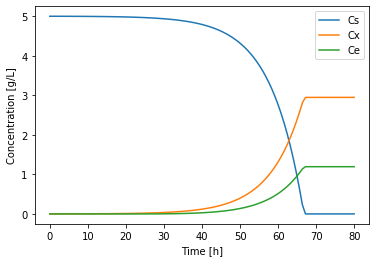

In [36]:
plt.plot(tspan, c_S*30, label = 'Cs')
plt.plot(tspan, c_X*MMX, label = 'Cx')
plt.plot(tspan, c_E*46, label = 'Ce')
plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

Text(0.5, 0, 'Time [h]')

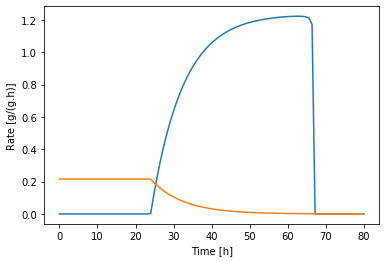

In [32]:
plt.plot(tspan, r_E*46, label = 'r_E')
plt.plot(tspan, r_H*1, label = 'r_H')
plt.ylabel('Rate [g/(g.h)]')
plt.xlabel('Time [h]')

In the graph above, we can observe that the fermentation pathway was followed after about 24 hours, when ethanol starts being produced exponentially and the hydrogen concentration becomes a straight line (thus, the production rate of hydrogen stays constant). 

Text(0.5, 0, 'Time [h]')

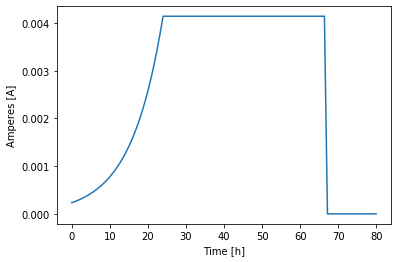

In [24]:
F_H = r_H*c_X*V*(1/60)*(1/60)
H_atoms = F_H*6.022e23
N_electrons = H_atoms
Coulomb_per_second = N_electrons*1.60217646e-19

Ampere = Coulomb_per_second

plt.plot(tspan, Ampere)
#plt.plot(tspan, r_E)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

Finally, we can now see the current produced in the MFC. As we see here, the current increases exponentially for about 26 hours, it then reaches the asymptotic maximum of I_max, which was calculated as 0.00414 A previously. The current produced stays constant until the substrate is depleted, as stated earlier after 67 hours. 